# Object Predictions (Exp2)

In [1]:
##################Item Predicition 3AFC##############################################
#####################################################################################
#Subjects see S1 (which could be a relevant cue) then a target. They must report which
#target they see on every trial. The targets are presented quickly but all equally likely.
#When a relevant cue occurs subjects know which target to expect. There are 4 relevant cues
#and 4 neutral cues.

#TRIGGER INFO...
#    Cues (S1)
#rel_cue1A_Trig              = 1;
#rel_cue2A_Trig              = 21;
#rel_cue1B_Trig              = 2;
#rel_cue2B_Trig              = 22;
    
#neut_cue1A_Trig             = 31;
#neut_cue2A_Trig             = 32;
#neut_cue1B_Trig             = 33;
#neut_cue2B_Trig             = 34;
    
#    Targets (S2)
#targA_cued_Trig             = 101;
#targA_noCue_Trig            = 100;
#targB_cued_Trig             = 201;
#targB_noCue_Trig            = 200;
#neutS2_nopred_Trig          = 151;
#neutS2_predEr_Trig          = 150;
    
#maskTrigger                 = 88;

# Set Up

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: %90 !important;}</style>"))

import mne
mne.sys_info()

Platform:      Linux-4.15.0-74-generic-x86_64-with-debian-stretch-sid
Python:        2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15)  [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Executable:    /home/sage/anaconda2/bin/python
CPU:           x86_64: 8 cores
Memory:        31.4 GB

mne:           0.17.dev0
numpy:         1.12.1 {lapack=mkl_intel_lp64, blas=mkl_intel_lp64}
scipy:         0.19.0
matplotlib:    2.0.2 {backend=module://ipykernel.pylab.backend_inline}

sklearn:       0.18.1
nibabel:       Not found
mayavi:        Not found
pycuda:        Not found
skcuda:        Not found
pandas:        0.20.1


In [5]:
#Load import packages
%matplotlib inline
%config InlineBackend.figure_format='retina'


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import scipy.ndimage
import copy
import os

from glob import glob


mne.set_log_level(False)
from mne.epochs import equalize_epoch_counts
from mne.time_frequency import tfr_morlet, tfr_multitaper, tfr_stockwell
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test

In [4]:
# set experimental path
sourceloc  = '/home/sage/Dropbox/Sage/Hbaws28/Projects/itemPred/Analysis/Data/Python/'

# make templates for file names
out_template = sourceloc + "{1}/{0}-{1}.fif"

# set colors
NeutColor = '#D2D2D2'
RelColor  = "#446488"


# make event ids
conds     = ['rel cue1A', 'rel cue2A',  'rel cue1B ', 'rel cue2B', 
            'neut cue1', 'neut cue2',  'neut cue3', 'neut cue4']

triggers  = [ 1,   21,  2,  22, 
            31, 32, 33, 34]

event_ids = dict(zip(conds, triggers))

# define bad subjects
bad_subjs = {}

# make dictonary of good subjects
subjs = {file.split("/")[-1].split("-")[0]
         for file in glob(sourceloc + "arvepo/*_cue-arvepo.fif")}
if bool(bad_subjs): 
    subjs = list(sorted(list(subjs - bad_subjs)))
else: 
    subjs = list(sorted(list(subjs)))    
    
# return the amount of subjects and the list of subjects
numSubs = len(subjs)
print(numSubs)
subjs

30


['s01_cue',
 's02_cue',
 's03_cue',
 's04_cue',
 's05_cue',
 's06_cue',
 's07_cue',
 's08_cue',
 's09_cue',
 's10_cue',
 's11_cue',
 's12_cue',
 's13_cue',
 's14_cue',
 's15_cue',
 's16_cue',
 's17_cue',
 's18_cue',
 's19_cue',
 's20_cue',
 's21_cue',
 's22_cue',
 's23_cue',
 's24_cue',
 's25_cue',
 's26_cue',
 's27_cue',
 's28_cue',
 's29_cue',
 's30_cue']

# ERPs

In [5]:
#Okay now load the epochs and combine the cue conditions
conds     = ['Rel Cue', 'Neutral Cue']
triggers  = [100, 130]
event_ids = dict(zip(conds, triggers))

# load the epoched data
all_epochs = []
for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name, "arvepo"), verbose='error')
        epochs.events[np.in1d(epochs.events[:,2], [1, 21, 2, 22]),2]    = 100 #combine trials that showed a relevant cue
        epochs.events[np.in1d(epochs.events[:,2], [31, 32, 33, 34]),2]  = 130 #now combine the trials that showed neutral cues
        
        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        epochs.filter(l_freq= None, h_freq=40, fir_design="firwin")

        print(epochs)
        all_epochs.append(epochs)
        
print('loaded ' + str(len(all_epochs)) + ' epochs') 

# get the avarage for each condition per subject
all_evokeds = {cond: [epochs[cond].average() for epochs in all_epochs] for cond in conds}

# Now we should look at the contrasts, here we can subtract the neutral from the relevant cue trial...
contrasts = [mne.combine_evoked([all_evokeds['Rel Cue'][sub], - all_evokeds['Neutral Cue'][sub]], 
                           weights = 'equal') for sub in range(numSubs)]

starting s01_cue
<EpochsFIF  |   1366 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~153.4 MB, data loaded, with metadata,
 'Neutral Cue': 683
 'Rel Cue': 683>
starting s02_cue
<EpochsFIF  |   1336 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~150.0 MB, data loaded, with metadata,
 'Neutral Cue': 668
 'Rel Cue': 668>
starting s03_cue
<EpochsFIF  |   1352 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~151.8 MB, data loaded, with metadata,
 'Neutral Cue': 676
 'Rel Cue': 676>
starting s04_cue
<EpochsFIF  |   1300 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~146.0 MB, data loaded, with metadata,
 'Neutral Cue': 650
 'Rel Cue': 650>
starting s05_cue
<EpochsFIF  |   1362 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~152.9 MB, data loaded, with metadata,
 'Neutral Cue': 681
 'Rel Cue': 681>
starting s06_cue
<EpochsFIF  |   1308 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~146.9 MB, data loaded, with metadata,
 'Neutral Cue': 654
 'Rel Cue': 654

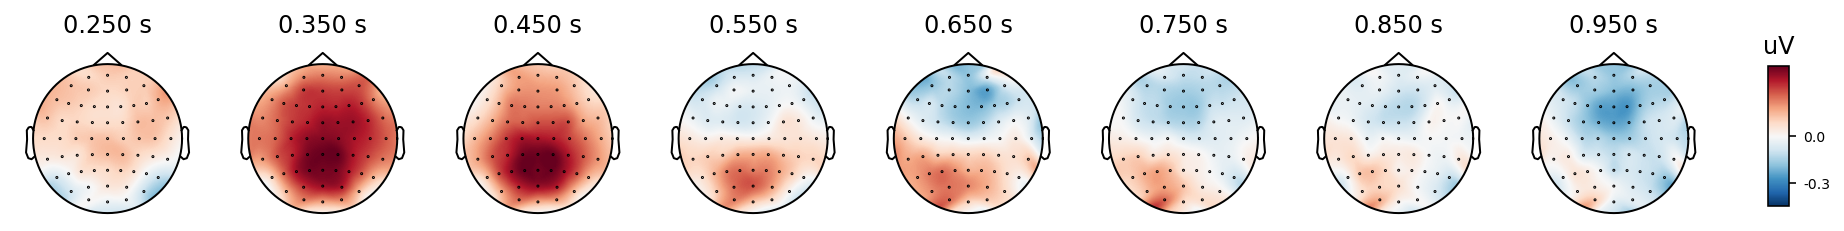

In [6]:
#Create an average across subjects in order to plot the topo
subNum      = 0
cue_data    = []
plotAll     = True

if plotAll:
    #Extract the data for each subject
    for sub in range(numSubs):    
        cue_data.append(contrasts[sub].data);
        
    cue_avg = np.mean(cue_data,0) # take the average of the subjects

    #Create a copy of the evoked structure and then replace the data witht the average data
    cue_evoked = copy.deepcopy(contrasts[0])
    cue_evoked.data = cue_avg
    
else:
    print(subjs[subNum])
    cue_evoked = copy.deepcopy(contrasts[subNum])

#Plot em'
times = [.25, .35, .45, .55, .65, .75, .85, .95]
cue_evoked.plot_topomap(times = times, contours = 0); 


In [7]:
#Extract relevant data for the ERPs (P3 and CNV)
cue_data_P3  = []
neut_data_P3 = []

cue_data_cnv  = []
neut_data_cnv = []

#get out the data
for sub in range(numSubs):
    tmp_cue = copy.deepcopy(all_evokeds['Rel Cue'][sub])
    tmp_neut = copy.deepcopy(all_evokeds['Neutral Cue'][sub])
    
    elecs = ["PZ", "P1", "P2", "POZ", "CPZ"]# These electrodes are often assoicated with the P3    
    cue_data_P3.append(np.mean(tmp_cue.pick_channels(elecs).data,0))
    neut_data_P3.append(np.mean(tmp_neut.pick_channels(elecs).data,0))
    
    tmp_cue = copy.deepcopy(all_evokeds['Rel Cue'][sub])
    tmp_neut = copy.deepcopy(all_evokeds['Neutral Cue'][sub])
    
    elecs = ["FZ", "F1", 'F2', 'FCZ', 'AFZ']# These electrodes are often assoicated with the CNV
    cue_data_cnv.append(np.mean(tmp_cue.pick_channels(elecs).data,0))
    neut_data_cnv.append(np.mean(tmp_neut.pick_channels(elecs).data,0))
    

### stats

In [30]:
P3_meff  = np.array(cue_data_P3) - np.array(neut_data_P3)
cnv_meff  = np.array(cue_data_cnv) - np.array(neut_data_cnv)


t_P3, clusters_P3, cluster_pv_P3, H0_P3             = permutation_cluster_1samp_test(P3_meff)
t_cnv, clusters_cnv, cluster_pv_cnv, H0_cnv         = permutation_cluster_1samp_test(cnv_meff)

In [31]:
times = epochs.times

# get arrays of siginficant clusters for p3

p3_mask_05 = []
p3_mask_01 = []

sig_times = np.asarray(clusters_P3)[cluster_pv_P3<.05]
for i in range(len(sig_times)):
    p3_mask_05 = np.append(p3_mask_05,(times[sig_times[i][0]]))
    
sig_times = np.asarray(clusters_P3)[cluster_pv_P3<.01]
for i in range(len(sig_times)):
    p3_mask_01 = np.append(p3_mask_01,(times[sig_times[i][0]]))

    
# get arrays of siginficant clusters for cnv

cnv_mask_05 = []
cnv_mask_01 = []

sig_times = np.asarray(clusters_cnv)[cluster_pv_cnv<.05]
for i in range(len(sig_times)):
    cnv_mask_05 = np.append(cnv_mask_05,(times[sig_times[i][0]]))

sig_times = np.asarray(clusters_cnv)[cluster_pv_cnv<.01]
for i in range(len(sig_times)):
    cnv_mask_01 = np.append(cnv_mask_01,(times[sig_times[i][0]]))


In [71]:
p3_mask_05

array([ 0.29 ,  0.295,  0.3  ,  0.305,  0.31 ,  0.315,  0.32 ,  0.325,
        0.33 ,  0.335,  0.34 ,  0.345,  0.35 ,  0.355,  0.36 ,  0.365,
        0.37 ,  0.375,  0.38 ,  0.385,  0.39 ,  0.395,  0.4  ,  0.405,
        0.41 ,  0.415,  0.42 ,  0.425,  0.43 ,  0.435,  0.44 ,  0.445,
        0.45 ,  0.455,  0.46 ,  0.465,  0.47 ,  0.475,  0.48 ,  0.485,
        0.49 ,  0.495,  0.5  ,  0.505,  0.51 ,  0.515,  0.52 ,  0.525,
        0.53 ,  0.535,  0.54 ,  0.545])

### plots

/home/sage/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/sage/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


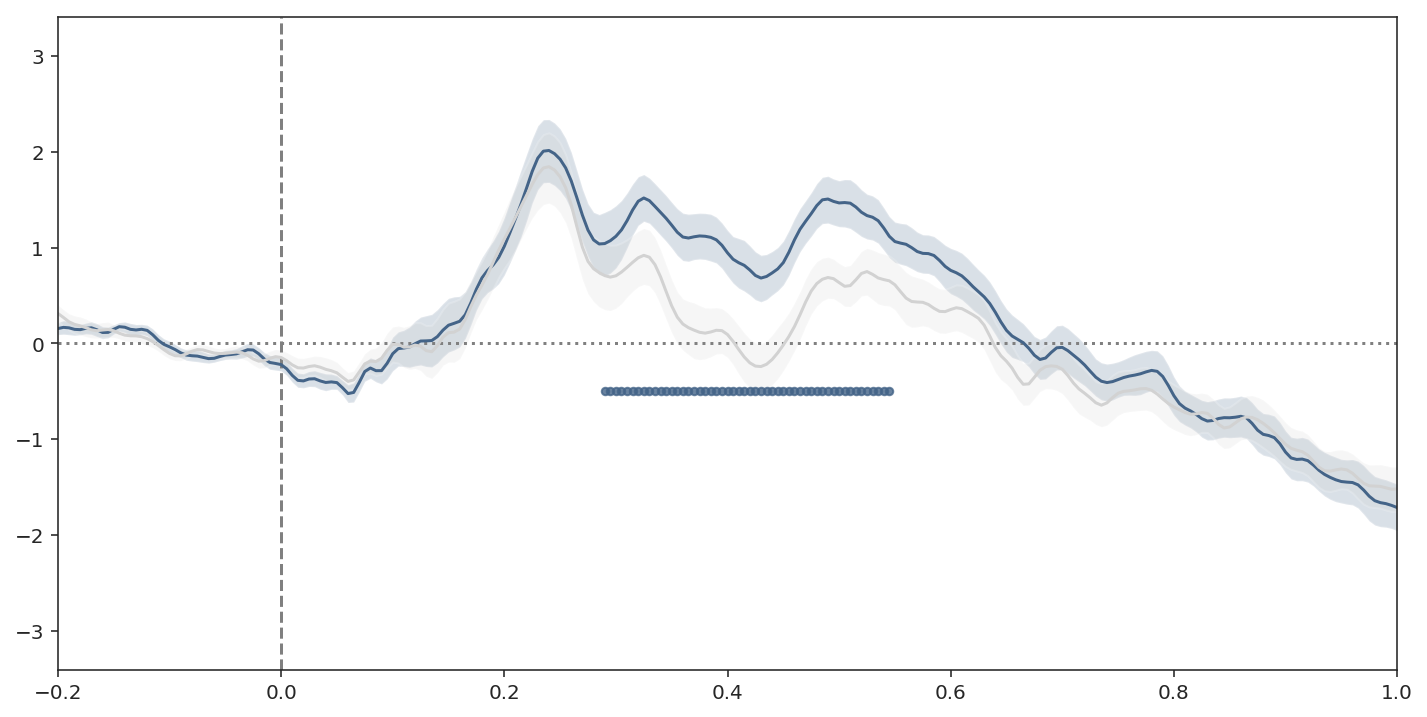

In [11]:
#Now plotting, P3
times = epochs.times

cue_data_P3_scaled = [x * 10**6 for x in cue_data_P3]
neut_data_P3_scaled = [x * 10**6 for x in neut_data_P3]

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.set_ylim([-3.4, 3.4])
colors = {'Identity Cue': RelColor,'Neutral Cue': NeutColor}


sns.tsplot(cue_data_P3_scaled, time=times, color=colors, ci=[68], condition = 'Identity Cue', legend = False)
sns.tsplot(neut_data_P3_scaled, time=times, color=colors, ci=[68], condition = 'Neutral Cue',legend = False)

sns.regplot(x = p3_mask_01, y=np.ones(p3_mask_05.shape)*-.5, fit_reg=False, color = RelColor, scatter_kws ={'s':14})

ax.legend()
#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/P3_l2c.png', format = 'png', dpi = 1000)


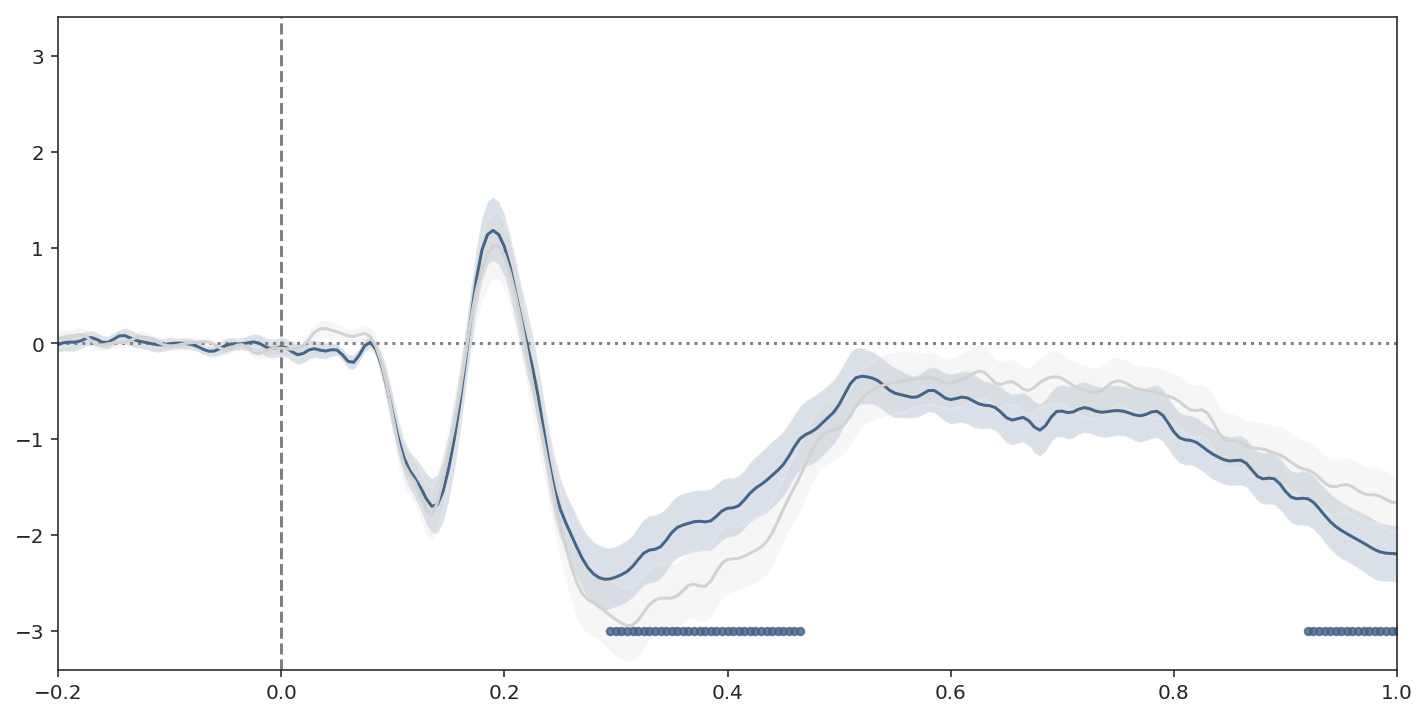

In [12]:
#Now plotting, CNV

cue_data_cnv_scaled = [x * 10**6 for x in cue_data_cnv]
neut_data_cnv_scaled = [x * 10**6 for x in neut_data_cnv]

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(12, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.set_ylim([-3.4, 3.4])
colors = {'Identity Cue': RelColor,'Neutral Cue': NeutColor}


sns.tsplot(cue_data_cnv_scaled, time=times, color=colors, ci=[68], condition = 'Identity Cue', legend = False)
sns.tsplot(neut_data_cnv_scaled, time=times, color=colors, ci=[68], condition = 'Neutral Cue',legend = False)


sns.regplot(x = cnv_mask_05, y=np.ones(cnv_mask_05.shape)*-3, fit_reg=False, color = RelColor, scatter_kws ={'s':14})


ax.legend()

#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/CNV_l2c.png', format = 'png', dpi = 1000)

# Time Frequency

In [5]:
#Okay now load the epochs and combine the cue conditions
conds     = ['Rel Cue', 'Neutral Cue']
triggers  = [100, 130]
event_ids = dict(zip(conds, triggers))

# load the epoched data
all_epochs_long = []
addon           = '_longEpo'
for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name + addon, "arvepo"), verbose='error')
        epochs.events[np.in1d(epochs.events[:,2], [1, 21, 2, 22]),2]    = 100 #combine trials that showed a relevant cue
        epochs.events[np.in1d(epochs.events[:,2], [31, 32, 33, 34]),2]  = 130 #now combine the trials that showed neutral cues
        
        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        print(epochs)
        all_epochs_long.append(epochs)
        
print('loaded ' + str(len(all_epochs_long)) + ' epochs') 

starting s01_cue
<EpochsFIF  |   1366 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~185.2 MB, data loaded, with metadata,
 'Neutral Cue': 683
 'Rel Cue': 683>
starting s02_cue
<EpochsFIF  |   1334 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~180.8 MB, data loaded, with metadata,
 'Neutral Cue': 667
 'Rel Cue': 667>
starting s03_cue
<EpochsFIF  |   1346 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~182.5 MB, data loaded, with metadata,
 'Neutral Cue': 673
 'Rel Cue': 673>
starting s04_cue
<EpochsFIF  |   1298 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~176.0 MB, data loaded, with metadata,
 'Neutral Cue': 649
 'Rel Cue': 649>
starting s05_cue
<EpochsFIF  |   1360 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~184.4 MB, data loaded, with metadata,
 'Neutral Cue': 680
 'Rel Cue': 680>
starting s06_cue
<EpochsFIF  |   1314 events (all good), -0.2 - 1.25 sec, baseline [-0.2, 0], ~178.1 MB, data loaded, with metadata,
 'Neutral Cue': 6

In [6]:
# Check if the sub already has a tfr for each condition if they 
# dont, make one, if they do, load it up and add it to the power list

overwrite = False

conds     = ['Rel Cue', 'Neutral Cue']
power     = {cond:[] for cond in sorted(conds)}

freqs     = np.asarray(range(3,40)) # define frequencies of interest
n_cycles  = freqs *.4  # (T = n_cycles / freq) so this is a 400ms time window

for sub in range(numSubs):
    print('Starting ' + subjs[sub])
    tfr = []
    for cond in conds:
        print(cond)
        fname = sourceloc + 'tfr/' + subjs[sub] + '_' + cond[:3] + '-tfr.h5'

        if  not(os.path.exists(fname)) or overwrite == True:
            tfr_cur   = tfr_morlet(all_epochs_long[sub][cond], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4)
            tfr_cur.save(fname, overwrite=overwrite)
        else: 
            tfr_cur = mne.time_frequency.read_tfrs(fname=fname)[0]
            
        power[cond].append(tfr_cur)


    power['Rel Cue'][sub].data = ((power['Rel Cue'][sub].data - power['Neutral Cue'][sub].data) / (power['Rel Cue'][sub].data + power['Neutral Cue'][sub].data)) *100

print('done')

Starting s01_cue
Rel Cue
Neutral Cue
Starting s02_cue
Rel Cue
Neutral Cue
Starting s03_cue
Rel Cue
Neutral Cue
Starting s04_cue
Rel Cue
Neutral Cue
Starting s05_cue
Rel Cue
Neutral Cue
Starting s06_cue
Rel Cue
Neutral Cue
Starting s07_cue
Rel Cue
Neutral Cue
Starting s08_cue
Rel Cue
Neutral Cue
Starting s09_cue
Rel Cue
Neutral Cue
Starting s10_cue
Rel Cue
Neutral Cue
Starting s11_cue
Rel Cue
Neutral Cue
Starting s12_cue
Rel Cue
Neutral Cue
Starting s13_cue
Rel Cue
Neutral Cue
Starting s14_cue
Rel Cue
Neutral Cue
Starting s15_cue
Rel Cue
Neutral Cue
Starting s16_cue
Rel Cue
Neutral Cue
Starting s17_cue
Rel Cue
Neutral Cue
Starting s18_cue
Rel Cue
Neutral Cue
Starting s19_cue
Rel Cue
Neutral Cue
Starting s20_cue
Rel Cue
Neutral Cue
Starting s21_cue
Rel Cue
Neutral Cue
Starting s22_cue
Rel Cue
Neutral Cue
Starting s23_cue
Rel Cue
Neutral Cue
Starting s24_cue
Rel Cue
Neutral Cue
Starting s25_cue
Rel Cue
Neutral Cue
Starting s26_cue
Rel Cue
Neutral Cue
Starting s27_cue
Rel Cue
Neutral Cue
S

In [7]:
#Create an average across subjects in order to plot the topo
pwr_data = []

for sub in range(numSubs):   
    pwr_data.append(power['Rel Cue'][sub].data);

pwr_avg = np.mean(pwr_data,0)

#Create a copy of the evoked structure and then replace the data witht the average data
pwr = copy.deepcopy(power['Rel Cue'][0])

pwr.data = pwr_avg

In [8]:
#Extract average across a subsection of relevant electrodes
elecs = ['P3','P2', 'Pz', 'P1','P3','PO8' 'PO4', 'POz', 'PO3','PO7', 'O1', 'Oz', 'O2']

times = power['Rel Cue'][0].times

subNum       = 0
pwr_data     = []
alphaTS_data = []

for sub in range(numSubs):
    tmp = copy.deepcopy(power['Rel Cue'][sub])
    sub_data = np.mean(tmp.pick_channels(elecs).data,0)
    sub_data = scipy.ndimage.gaussian_filter(sub_data,sigma=.5)
    pwr_data.append(sub_data);
    
    sub_alphaTS = np.mean(sub_data[5:9],0)
    alphaTS_data.append(sub_alphaTS);

pwr_avg = np.mean(pwr_data,0)

### stats

In [9]:
# run cluster test vs 0 and vs each other
t_alpha, clusters_alpha, cluster_pv_alpha, H0_alpha = permutation_cluster_1samp_test(np.asarray(pwr_data), out_type='mask')

mask_alpha_05 = np.asarray(clusters_alpha)[cluster_pv_alpha<.05]

In [10]:
t_TS_alpha, clusters_TS_alpha, cluster_pv_TS_alpha, H0_TS_alpha             = permutation_cluster_1samp_test(np.asarray(alphaTS_data))

In [11]:
##Alpha of .05

# get arrays of siginficant clusters for easy vs o
TS_mask_05 = []
sig_times = np.asarray(clusters_TS_alpha)[cluster_pv_TS_alpha<.05]
for i in range(len(sig_times)):
    TS_mask_05 = np.append(TS_mask_05,(times[sig_times[i][0]]))

### plots

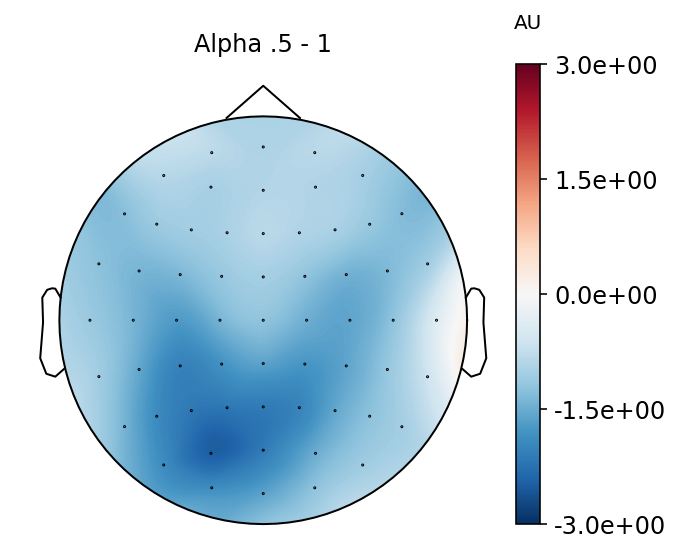

In [12]:
#Plot Alpha 
vmin, vmax = -3, 3
fig, axis = plt.subplots(figsize=(12, 4))

pwr.plot_topomap(tmin=.5, tmax=1,fmin=8, fmax=12, vmin = vmin, vmax = vmax, title = 'Alpha .5 - 1', axes= axis, show = False, contours=0)

mne.viz.tight_layout()
plt.show()

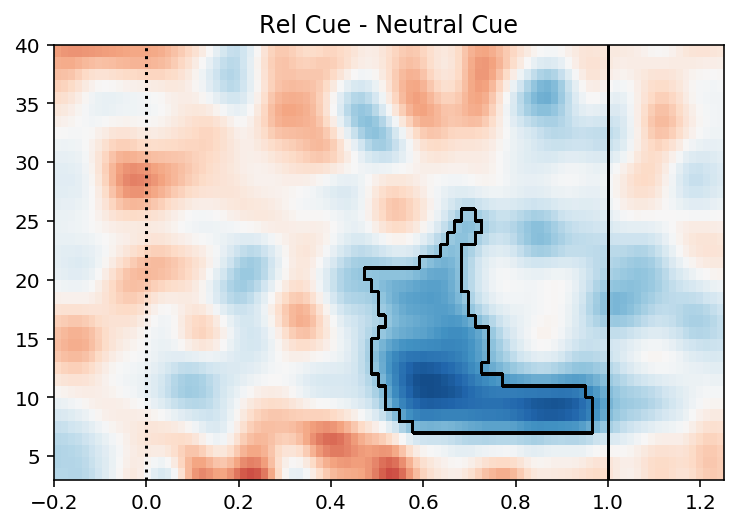

In [13]:
fig, axes = plt.subplots()
extent=(-.2, 1.25, 3, 40)

#Plot 
im = axes.imshow(pwr_avg, cmap = 'RdBu_r', vmin = -3, vmax = 3, extent=extent, origin="lower", aspect="auto");
#plt.colorbar(im)

#Add significance contour
big_mask = np.kron(np.squeeze(mask_alpha_05), np.ones((10,10))) #interpolate to 10x real data to fix contours
axes.contour(big_mask, colors='black', extent=extent, 
             linewidths=.75, corner_mask=False, antialiased=False)

axes.axvline(x = 0, color = 'k', linestyle = ':')
axes.axvline(x = 1, color = 'k')

axes.title.set_text('Rel Cue - Neutral Cue')

#fig.savefig('/home/sage/Dropbox/Sage/tdPlots/alpha_Easy.png', format = 'png', dpi = 1000)


/home/sage/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


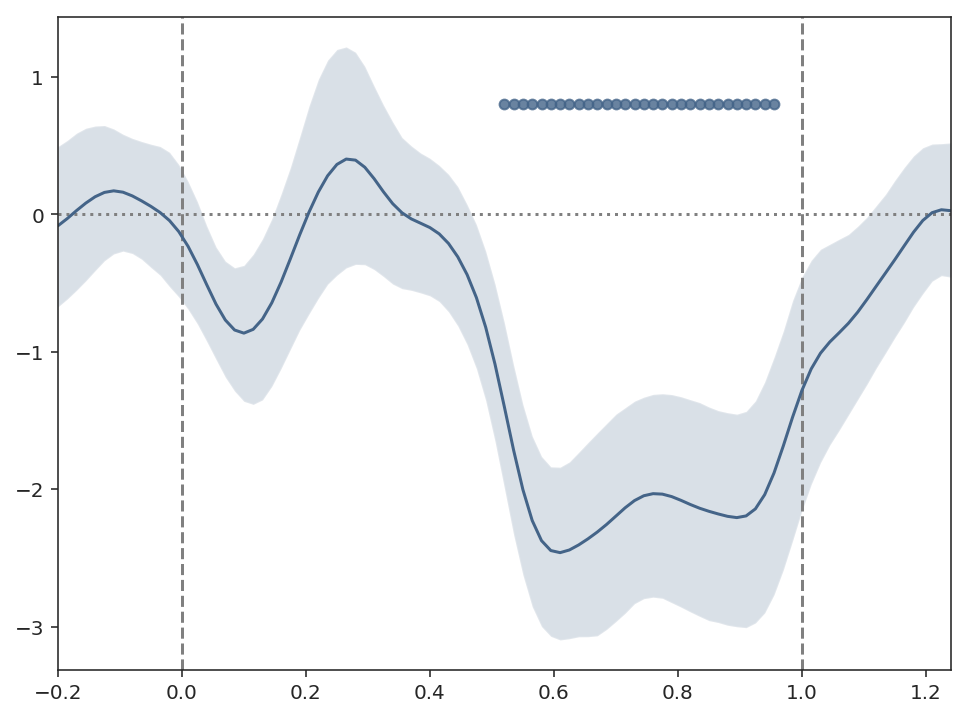

In [14]:
#Next the timecourse
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(0, color='grey', linestyle=':')
ax.axvline(0, color='grey', linestyle='--')
ax.axvline(1, color='grey', linestyle='--')


#colors = {'Easy Cue': RelColor}

sns.tsplot(alphaTS_data, time=times, color=RelColor, ci=[68], legend = False)

sns.regplot(x = TS_mask_05, y=np.ones(TS_mask_05.shape)*.8, fit_reg=False, color = RelColor, scatter_kws ={'s':24})



### Beta vs. Alpha

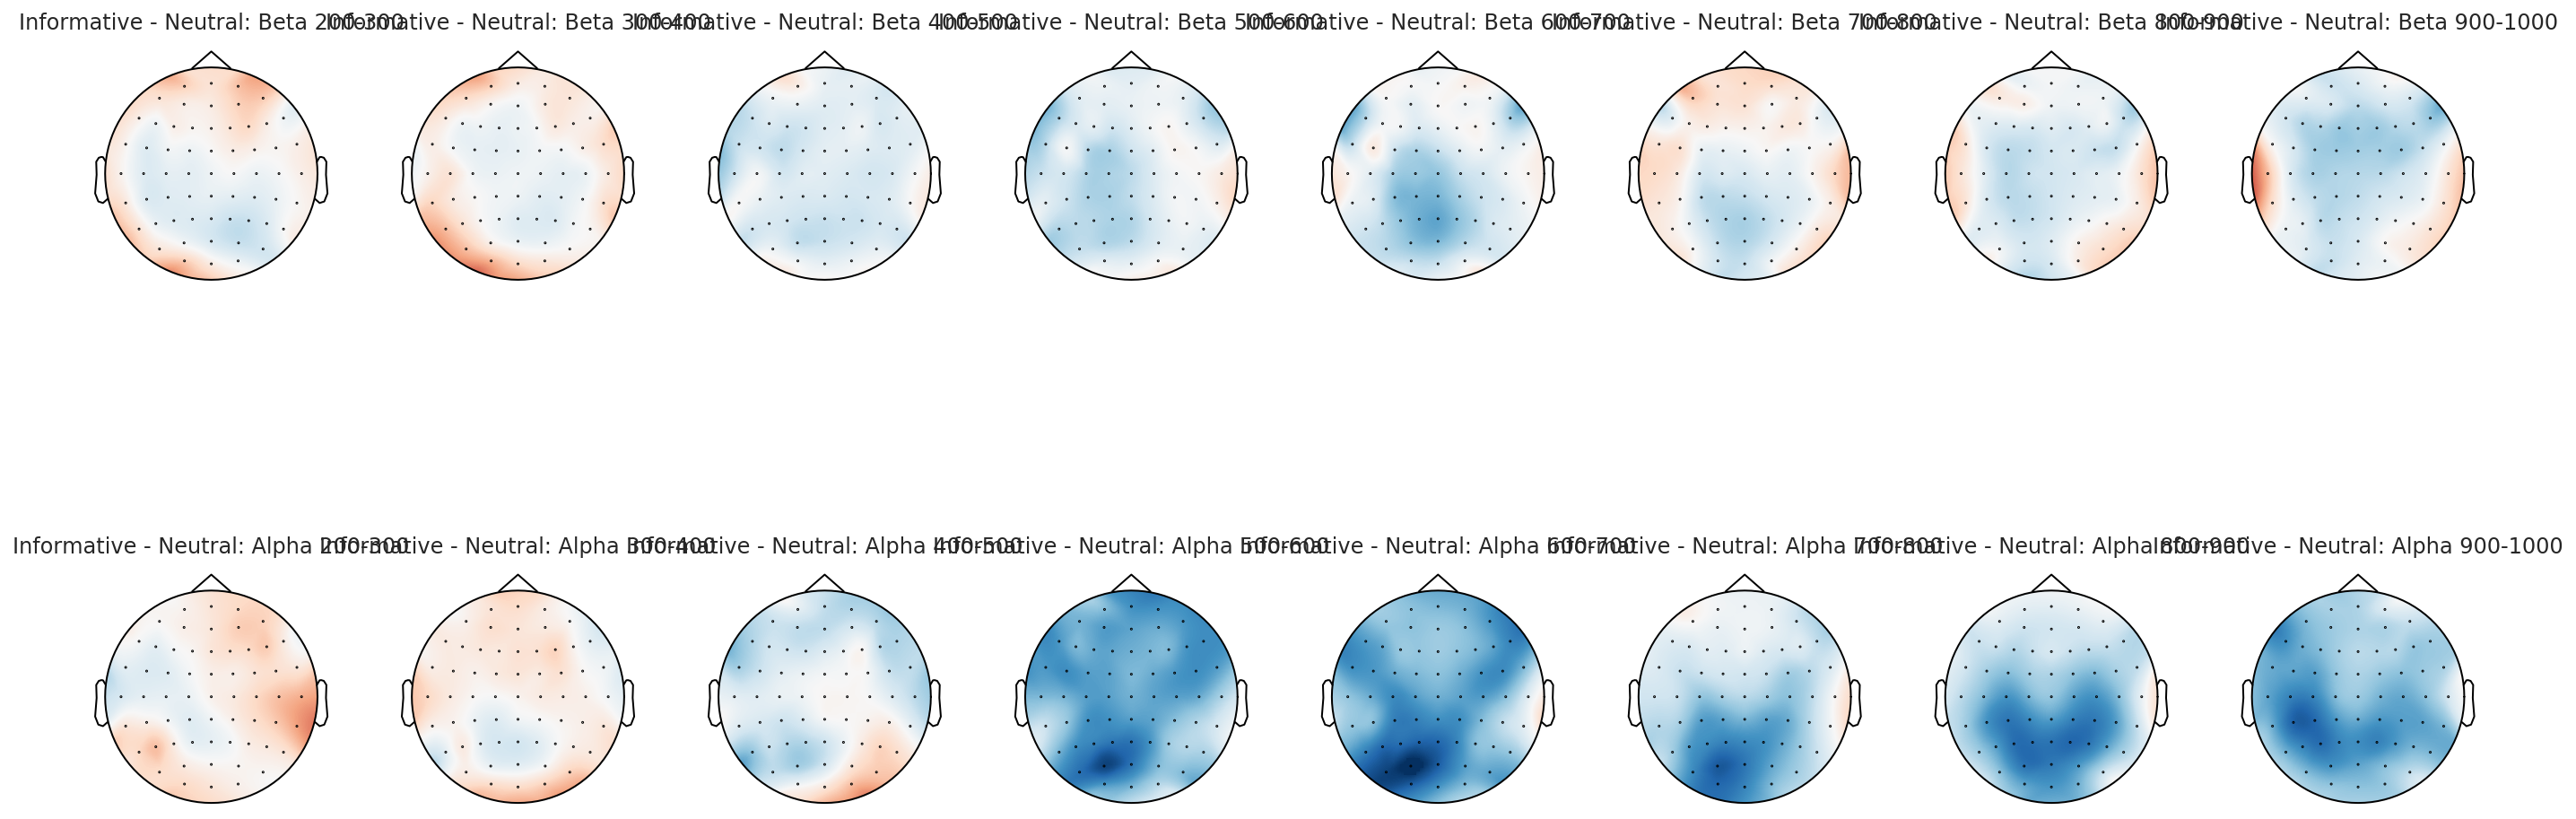

In [20]:
#Beta
vmin    = -3
vmax    = 3

fig, ax      = plt.subplots(ncols=8, nrows=2, figsize=(24, 9))
times        = [(.2,.3), (.3,.4), (.4,.5), (.5,.6), (.6,.7), (.7,.8), (.8,.9), (.9,1)]

for i in range(8):
    pwr.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=13, fmax=30, vmin = vmin, vmax = vmax, axes= ax[0,i], title = 'Informative - Neutral: Beta ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);
    pwr.plot_topomap(tmin=times[i][0], tmax=times[i][1], fmin=8, fmax=12, vmin = vmin, vmax = vmax, axes= ax[1,i], title = 'Informative - Neutral: Alpha ' + str(int(times[i][0] * 1000)) + '-' + str(int(times[i][1] * 1000)), show = False, contours = 0, colorbar=False);


## Target decoding (Figure 7)

In [14]:
#Load some goodies for decoding

from sklearn.pipeline import make_pipeline
from sklearn.lda import LDA
from mne.decoding import (Vectorizer, SlidingEstimator, GeneralizingEstimator, cross_val_multiscore)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.ndimage


In [15]:
#Make the classifier
clf = make_pipeline(
    Vectorizer(),
    PCA(n_components=.99),
    StandardScaler(),
    LDA())




sl  = SlidingEstimator(clf,  scoring='roc_auc')
gat = GeneralizingEstimator(clf, scoring='roc_auc')

In [16]:
def get_scores(epochs, class1):
    X = epochs.get_data()
    y = epochs.events[:, -1] == class1
    scores = cross_val_multiscore(sl, X, y, cv=5, n_jobs=4)
    return scores

In [17]:
# set experimental path
sourceloc  = '/home/sage/Dropbox/Sage/Hbaws28/Projects/itemPred/Analysis/Data/Python/'

# make templates for file names
out_template = sourceloc + "{1}/{0}-{1}.fif"

# make event ids
# make event ids
conds     = ['targA cued', 'targA noCue',
            'targB cued', 'targB noCue', 
            'neutS2 noPred','neutS2 predEr']

triggers   = [101, 100,
            201,  200, 
            151, 150]

event_ids = dict(zip(conds, triggers))

# define bad subjects
#bad_subjs = {'s03_tar'}
bad_subjs = {}
#bad_subjs = {'s01_tar', 's02_tar', 's03_tar', 's04_tar', 's05_tar', 's06_tar', 's07_tar'}


# make dictonary of good subjects
subjs = {file.split("/")[-1].split("-")[0]
         for file in glob(sourceloc + "arvepo/*_tar-arvepo.fif")}
if bool(bad_subjs): subjs = list(sorted(list(subjs - bad_subjs)))

# return the amount of subjects
numSubs = len(subjs)
numSubs

30

##### Predicted TargetA vs Predicted Target B

In [21]:
conds     = ['TargetA', 'TargetB']
triggers  = [101, 201]
event_ids = dict(zip(conds, triggers))
class1    = 101 #TargetA
counter   = 1
elecs2use = ['P7','P3','P5','P1' 'Pz', 'P2','P4','P6','P8','PO8' 'PO4', 'POz', 'PO3','PO7', 'O1', 'Oz', 'O2']
if len(elecs2use) > 0:
    useSubset = True
else:
    useSubset = False
    
all_epochs_decoding          = []
scores_predTarg_all_decoding = []
scores_predTarg_subset_decoding = []

for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name, "arvepo"), verbose='error')

        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        epochs.drop(~(np.in1d(epochs.events[:,2], [101,201])))        # drop the irrelevant events  
        
        #check if we should only use a subset of the channels
        if useSubset:
            epochs.pick_channels(elecs2use)
            
        print(epochs)
        all_epochs_decoding.append(epochs)
print(len(all_epochs_decoding))

for epochs in all_epochs_decoding:
    print(str(counter) + ' out of ' + str(len(all_epochs_decoding)) + ' subs')
    counter    = counter + 1
    scores     = get_scores(epochs, class1)
    if useSubset:
        scores_predTarg_subset_decoding.append(scores)
    else:
        scores_predTarg_all_decoding.append(scores)


starting s01_tar
<EpochsFIF  |   426 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.3 MB, data loaded, with metadata,
 'TargetA': 213
 'TargetB': 213>
starting s02_tar
<EpochsFIF  |   472 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~8.0 MB, data loaded, with metadata,
 'TargetA': 236
 'TargetB': 236>
starting s03_tar
<EpochsFIF  |   452 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.7 MB, data loaded, with metadata,
 'TargetA': 226
 'TargetB': 226>
starting s04_tar
<EpochsFIF  |   414 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.1 MB, data loaded, with metadata,
 'TargetA': 207
 'TargetB': 207>
starting s05_tar
<EpochsFIF  |   430 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.3 MB, data loaded, with metadata,
 'TargetA': 215
 'TargetB': 215>
starting s06_tar
<EpochsFIF  |   448 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.6 MB, data loaded, with metadata,
 'TargetA': 224
 'TargetB': 224>
starting s07_tar
<EpochsFIF 

##### Unpredicted TargetA vs Unpredicted Target B

In [18]:
conds     = ['TargetA', 'TargetB']
triggers  = [100, 200]
event_ids = dict(zip(conds, triggers))
class1    = 100 #TargetA
counter   = 1
elecs2use = ['P7','P3','P5','P1' 'Pz', 'P2','P4','P6','P8','PO8' 'PO4', 'POz', 'PO3','PO7', 'O1', 'Oz', 'O2']
if len(elecs2use) > 0:
    useSubset = True
else:
    useSubset = False
    
all_epochs_decoding            = []
scores_unpredTarg_all_decoding = []
scores_unpredTarg_subset_decoding = []

for ii, name in enumerate(sorted(subjs)):
    print('starting ' + name)
    if name not in bad_subjs:
        epochs = mne.read_epochs(out_template.format(name, "arvepo"), verbose='error')

        epochs.event_id = event_ids
        epochs.equalize_event_counts(event_ids=event_ids)
        epochs.drop(~(np.in1d(epochs.events[:,2], [100,200])))        # drop the irrelevant events  
        
        #check if we should only use a subset of the channels
        if useSubset:
            epochs.pick_channels(elecs2use)
            
        print(epochs)
        all_epochs_decoding.append(epochs)
print(len(all_epochs_decoding))

for epochs in all_epochs_decoding:
    print(str(counter) + ' out of ' + str(len(all_epochs_decoding)) + ' subs')
    counter    = counter + 1
    scores     = get_scores(epochs, class1)
    if useSubset:
        scores_unpredTarg_subset_decoding.append(scores)
    else:
        scores_unpredTarg_all_decoding.append(scores)



starting s01_tar
<EpochsFIF  |   436 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.4 MB, data loaded, with metadata,
 'TargetA': 218
 'TargetB': 218>
starting s02_tar
<EpochsFIF  |   434 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.4 MB, data loaded, with metadata,
 'TargetA': 217
 'TargetB': 217>
starting s03_tar
<EpochsFIF  |   450 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.7 MB, data loaded, with metadata,
 'TargetA': 225
 'TargetB': 225>
starting s04_tar
<EpochsFIF  |   514 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~8.7 MB, data loaded, with metadata,
 'TargetA': 257
 'TargetB': 257>
starting s05_tar
<EpochsFIF  |   456 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.8 MB, data loaded, with metadata,
 'TargetA': 228
 'TargetB': 228>
starting s06_tar
<EpochsFIF  |   436 events (all good), -0.2 - 0.8 sec, baseline [-0.2, 0], ~7.4 MB, data loaded, with metadata,
 'TargetA': 218
 'TargetB': 218>
starting s07_tar
<EpochsFIF 

In [48]:
#Get the times
times = epochs.times

#Get the averages
scores_predTarg_avg          = np.mean(scores_predTarg_subset_decoding,1)
scores_unpredTarg_avg        = np.mean(scores_unpredTarg_subset_decoding,1)

#Smooth
scores_predTarg_all_smooth   = scipy.ndimage.filters.gaussian_filter1d(scores_predTarg_avg,5)
scores_unpredTarg_all_smooth = scipy.ndimage.filters.gaussian_filter1d(scores_unpredTarg_avg,5)

#diff = scores_predTarg_avg - scores_unpredTarg_avg
diff = scores_predTarg_all_smooth[:,41:100]- scores_unpredTarg_all_smooth[:,41:100]

t_pvsup, clusters_pvsup, cluster_pv_pvsup, H0_pvsup             = permutation_cluster_1samp_test(diff)


In [49]:
cluster_pv_pvsup

array([ 0.08300781])

/home/sage/anaconda2/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


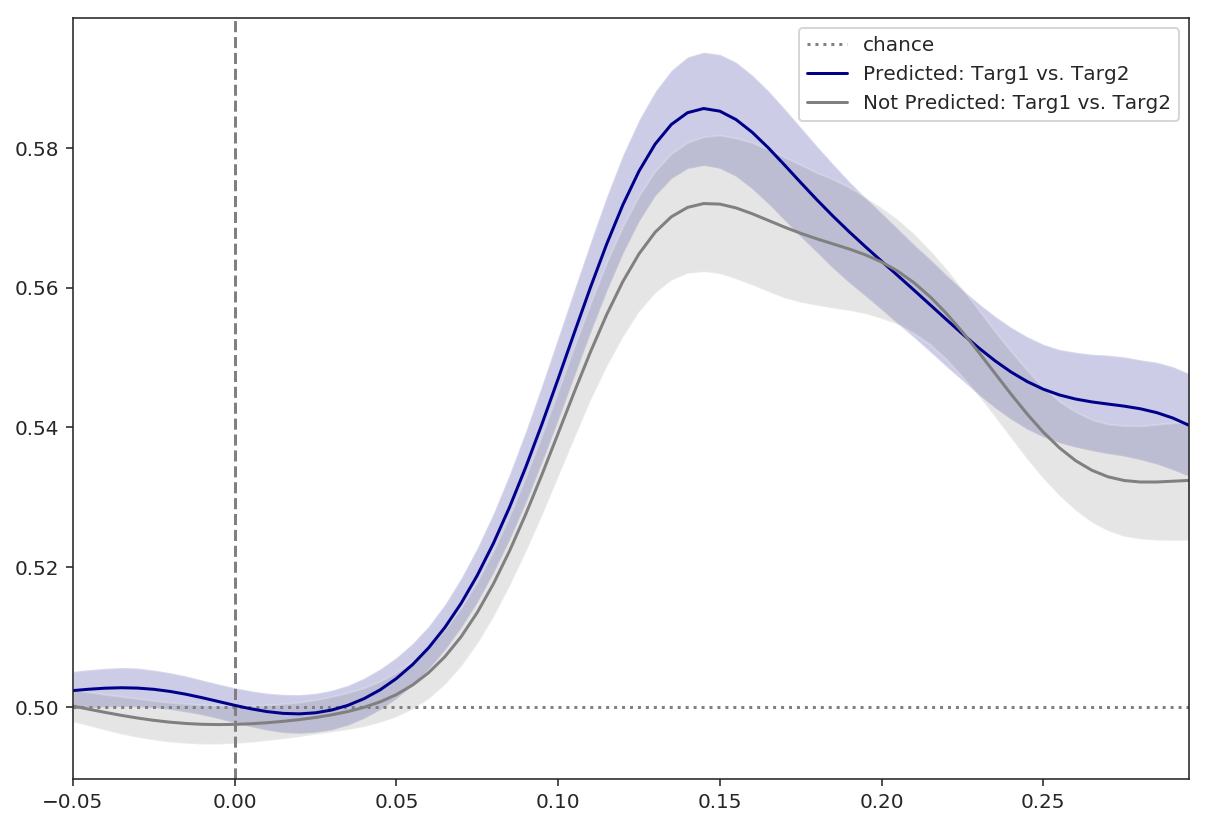

In [50]:
times = epochs.times 
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,7))
ax.axhline(.5, color='grey', linestyle=':', label='chance')
ax.axvline(0,  color='grey', linestyle='--')

sns.tsplot(scores_predTarg_all_smooth[:,30:100], time=times[30:100], color="darkblue", ci=[68], condition = 'Predicted: Targ1 vs. Targ2', legend = True)#
sns.tsplot(scores_unpredTarg_all_smooth[:,30:100], time=times[30:100], color="gray",  ci=[68], condition = 'Not Predicted: Targ1 vs. Targ2', legend = True)#



0.145


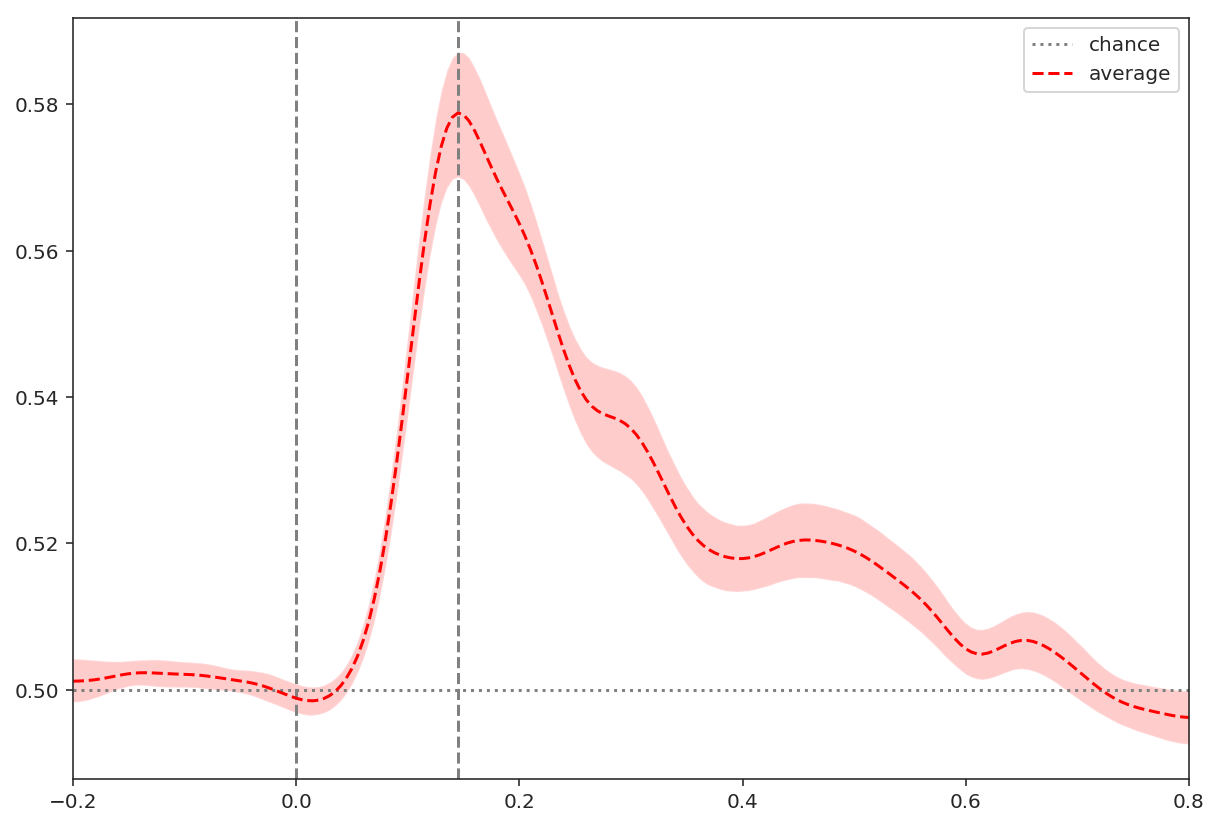

In [51]:
#times                 = epochs.times
#scores_predTarg_avg   = np.mean(scores_predTarg_all_decoding,1)
#scores_unpredTarg_avg = np.mean(scores_unpredTarg_all_decoding,1)
average               = np.mean([scores_predTarg_all_smooth, scores_unpredTarg_all_smooth],0)


sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,7))
ax.axhline(.5, color='grey', linestyle=':', label='chance')
ax.axvline(0,  color='grey', linestyle='--')
ax.axvline(times[np.argmax(np.mean(average,0),0)],  color='grey', linestyle='--')

sns.tsplot(average, time=times, color="red", linestyle='--', ci=[68], condition = 'average', legend = True)#
print(times[np.argmax(np.mean(average,0),0)])

In [52]:
#okay lets grab the average around the peak 

avg_peak_pred    = scores_predTarg_all_smooth[:,69]
avg_peak_unpred  = scores_unpredTarg_all_smooth[:,69]

data = {'predicted': avg_peak_pred, 'unpredicted': avg_peak_unpred}
df = pd.DataFrame(data)

(0.45, 0.6)

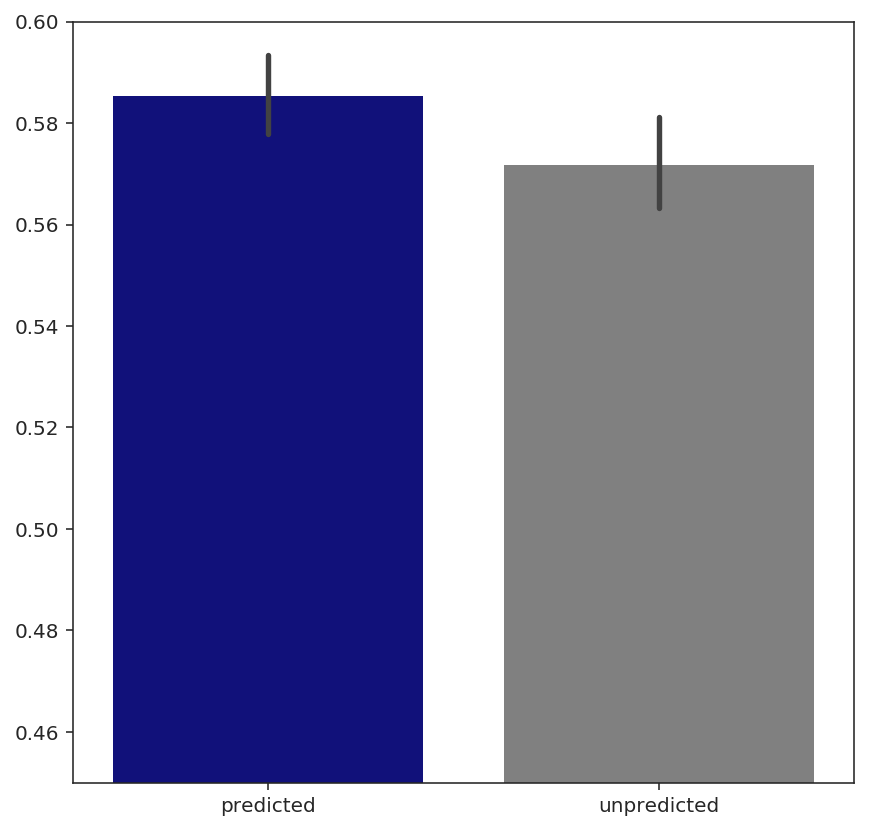

In [53]:
fig, ax = plt.subplots(figsize = (7,7))

colors = ['darkblue', 'gray']
sns.barplot(data = df, ci=68, palette=colors)
plt.ylim(.45,.60)

In [54]:
scipy.stats.ttest_rel(avg_peak_pred, avg_peak_unpred)

Ttest_relResult(statistic=2.8966038510431953, pvalue=0.0071055095039589677)